In [1]:
import cv2
import matplotlib.pyplot as plt
import sort
#from pydarknet import Detector , Image
#from pydarknet import Image as Im
from detect import Object_Detector
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import sort
from utils import *
#import torchvision.transforms.functional as fn

In [2]:
!pip freeze

absl-py==1.0.0
agate==1.6.2
agate-dbf @ file:///tmp/build/80754af9/agate-dbf_1600131906274/work
agate-excel @ file:///tmp/build/80754af9/agate-excel_1630598164320/work
agate-sql==0.5.6
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client==1.7.2
anaconda-navigator==2.1.1
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1610472525955/work
anyascii==0.3.1
anyio @ file:///C:/ci/anyio_1620153418380/work/dist
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037959010/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1613501047216/work
astropy @ file:///C:/ci/astropy_1617745647203/work
astunparse==1.6.3
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1615918855173/work
Babel @ file:///tmp/build/80754af9/babel_162

sacremoses==0.0.46
scikit-image==0.18.1
scikit-learn==1.1.2
scipy @ file:///C:/ci/scipy_1616703433439/work
seaborn @ file:///tmp/build/80754af9/seaborn_1629307859561/work
selenium==4.1.3
Send2Trash @ file:///tmp/build/80754af9/send2trash_1632406701022/work
sentencepiece==0.1.91
Shapely==1.8.1.post1
simplegeneric==0.8.1
singledispatch @ file:///tmp/build/80754af9/singledispatch_1614366001199/work
sip==4.19.13
six @ file:///C:/ci/six_1605187374963/work
smart-open==5.2.1
sniffio @ file:///C:/ci/sniffio_1614030707456/work
snowballstemmer @ file:///tmp/build/80754af9/snowballstemmer_1637937080595/work
sortedcollections @ file:///tmp/build/80754af9/sortedcollections_1611172717284/work
sortedcontainers @ file:///tmp/build/80754af9/sortedcontainers_1623949099177/work
soupsieve @ file:///tmp/build/80754af9/soupsieve_1636706018808/work
spacy==3.2.0
spacy-legacy==3.0.8
spacy-loggers==1.0.1
Sphinx @ file:///tmp/build/80754af9/sphinx_1620777493457/work
sphinxcontrib-applehelp @ file:///home/ktietz/

In [3]:
classes = None
with open('./yolo/cfg/coco.data', 'r') as f:
    classes = [line.strip() for line in f.readlines()]
f.close()
#classes

In [4]:
image_path ='photo.jpg' 
input_image = plt.imread(image_path)
image=input_image.copy()

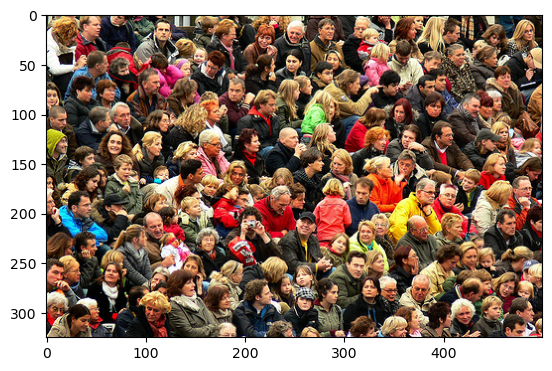

In [5]:
plt.imshow(image)
plt.show()

In [6]:
network = cv2.dnn.readNet('./yolo/yolov3.weights', './yolo/yolov3.cfg')

    
def crop_image(image_path):
    img = plt.imread(image_path)
    height = img.shape[0]
    width = img.shape[1]
    # Cut the image in half
    width_cutoff = width // 2
    height_cutoff=height//2
    left1 = img[height_cutoff:, :width_cutoff]
    right1 = img[:height_cutoff, width_cutoff:]
    right2 = img[:height_cutoff, :width_cutoff]
    left2 = img[height_cutoff:, width_cutoff:]
    return left1,right1,right2,left2

def get_yolo_output(input_image):
    image=input_image
    network.setInput(cv2.dnn.blobFromImage(image, 0.00392, (416,416), (0,0,0), True, crop=False))
    layer_names = network.getLayerNames()
    output_layers = [layer_names[i - 1] for i in network.getUnconnectedOutLayers()]
    outs = network.forward(output_layers)
    class_ids = []
    confidences = []
    boxes = []
    Width = image.shape[1]
    Height = image.shape[0]
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.2:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)
    kept_boxes=[]
    for i in indices:
        #i = i[0]
        box = boxes[i]
        if class_ids[i]==0:
            label = text = "{}: {:.4f}".format(classes[class_ids[i]], confidences[i])
            cv2.rectangle(image, (round(box[0]),round(box[1])), (round(box[0]+box[2]),round(box[1]+box[3])), (0, 0, 0), 2)
            cv2.putText(image, label, (round(box[0])-10,round(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            box.append(round(confidences[i],2))
            kept_boxes.append(box)
    return kept_boxes,image


In [7]:
kept_boxes,image=get_yolo_output(input_image)
image=(image-np.min(image))/(np.max(image)-np.min(image))

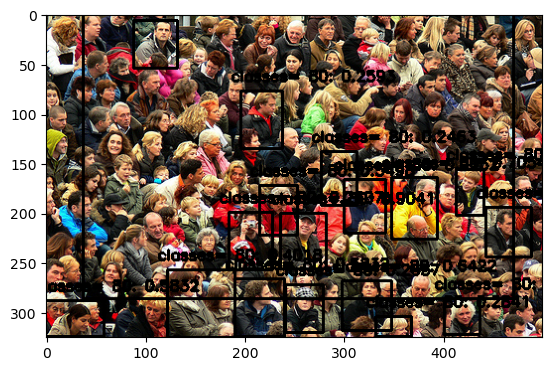

In [8]:
plt.imshow(image)
plt.show()

In [9]:
tracks = {}
person_tracker = sort.Sort()
video_filename='Building_video.mkv'
cap = cv2.VideoCapture(video_filename)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video_name='output_video.avi'
height, width, layers = (720, 1280, 3)
video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
track_data=pd.DataFrame(columns=['frame','person_id','x_coordinate','y_coordinate'])

i=0
while cap.isOpened():
# 2. Iterate through each frame in the video
    i=i+1
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    kept_boxes,image=get_yolo_output(img)
    
    #plt.imsave('./data/detections/frame{}.png'.format(i),image)
#    video.write(image)
    detections=[]
    for detection in kept_boxes: 
        cx,cy,w,h,score= detection
        x1, y1, x2, y2 = get_corner_coordinates([cx, cy, w, h])
        detection=[x1, y1, x2, y2, score]
        detections.append(detection)
    tracked_persons=person_tracker.update(np.array(detections))
    for x1, y1, x2, y2, personid in tracked_persons:
        center_pos = (int((x1 + x2)/2)*0.02, (int(y1 + y2)/2)*0.02,i)
        tracks[int(personid)] = tracks.get(personid, []) + [center_pos]
        new_row = {'frame':i, 'person_id':personid, 'x_coordinate':center_pos[0], 'y_coordinate':center_pos[1]}
        track_data = track_data.append(new_row, ignore_index=True)
        
    if i==2:
        print('video processed')
        cv2.destroyAllWindows()
        plt.imshow(image)
        ##video.release()  # releasing the video generated 
        break 

video processed


In [10]:
track_data.to_csv('frame_data.csv')

In [ ]:
printè